In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Embedding,Dense,Dropout,Bidirectional,LSTM,Input,GlobalAveragePooling1D,Flatten
import tensorflow_hub as hub
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
! pip install tensorflow_text
import tensorflow_text as text

# Dataset

In [3]:
train_data = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_train.csv')
val_data = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_valid.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_test.csv')

In [4]:
train_data.head()

,id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,0,He was answering a question about the criticis...,1,0,1,0,0,0,0,1,0,0,0,0
1,1,I'm going to start today's discussion thread w...,1,1,1,1,0,0,0,1,0,0,0,0
2,2,"By announcing the 395 self-quarantined, it pai...",1,1,1,1,0,0,0,1,0,0,0,0
3,3,"Likewise, sorry if I offended you. I’m not act...",1,0,1,1,0,0,0,1,0,0,0,0
4,4,"People infected by experience high fever, coug...",0,0,0,0,0,0,0,0,0,0,0,1


In [5]:
val_data.head()

,id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,0.0,He was answering a question about the criticis...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,I'm going to start today's discussion thread w...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.0,"By announcing the 395 self-quarantined, it pai...",1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,"Likewise, sorry if I offended you. I’m not act...",1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4.0,"People infected by experience high fever, coug...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
test_data.head()

,id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,0,&gt; # First passengers exit quarantined Japan...,0,1,0,1,0,0,1,0,1,0,0,0
1,1,"This is the best tl;dr I could make, [original...",0,0,0,0,0,0,0,0,0,0,0,1
2,2,Absolutely. Trade is good for everyone.\n\nBut...,0,0,1,0,0,0,0,0,0,0,0,0
3,3,He says the elderly should stay home. I have t...,0,0,0,1,0,0,0,1,0,0,0,0
4,4,&gt; A couple of million wont die in the US.\n...,0,1,0,1,0,0,0,1,1,1,0,0


In [7]:
train_sentiment_data = train_data.dropna()
train_sentiment_data = train_sentiment_data.reset_index(drop=True)

val_sentiment_data = val_data.dropna()
val_sentiment_data = val_sentiment_data.reset_index(drop=True)

test_sentiment_data = test_data.dropna()
test_sentiment_data = test_sentiment_data.reset_index(drop=True)

label_class = ['anger','anticipation','disgust','fear','joy','love','optimism','pessimism','sadness','surprise','trust','neutral']

input_data_train = train_sentiment_data['text'].values
label_data_train = train_sentiment_data[label_class].values

input_data_val = val_sentiment_data['text'].values
label_data_val = val_sentiment_data[label_class].values

input_data_test = test_sentiment_data['text'].values
label_data_test = test_sentiment_data[label_class].values

In [8]:
print('Input train shape: ', input_data_train.shape)
print('Label train shape: ', label_data_train.shape)
print('Input val shape: ', input_data_val.shape)
print('Label val shape: ', label_data_val.shape)
print('Input test shape: ', input_data_test.shape)
print('Label test shape: ', label_data_test.shape)

Input train shape:  (1493,)
Label train shape:  (1493, 12)
Input val shape:  (165,)
Label val shape:  (165, 12)
Input test shape:  (374,)
Label test shape:  (374, 12)


# Training with Pretrain Word Embedding

In [13]:
embedding = 'http://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(embedding,input_shape = [], dtype = tf.string, trainable=True)
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32,activation = 'relu'))
model.add(tf.keras.layers.Dense(16,activation = 'relu'))
model.add(tf.keras.layers.Dense(12,activation = 'sigmoid'))
model.summary()

adam = Adam(learning_rate=0.001)
model.compile(optimizer= adam, loss = 'binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy(name= 'binary_accuracy',dtype = None, threshold = 0.5))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_3 (Dense)             (None, 32)                1632      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 12)                204       
                                                                 
Total params: 48192964 (183.84 MB)
Trainable params: 48192964 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_google_embedding.h5',monitor= 'val_loss' )
history = model.fit(x = input_data_train, y = label_data_train, epochs = 50,validation_data=(input_data_val,label_data_val), callbacks = [callback_model])

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 0.6594 - binary_accuracy: 0.6100

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 22s 308ms/step - loss: 0.6594 - binary_accuracy: 0.6100 - val_loss: 0.5914 - val_binary_accuracy: 0.7066
Epoch 2/50
47/47 [==============================] - 12s 263ms/step - loss: 0.5591 - binary_accuracy: 0.7196 - val_loss: 0.5116 - val_binary_accuracy: 0.7677
Epoch 3/50
47/47 [==============================] - 13s 270ms/step - loss: 0.5069 - binary_accuracy: 0.7636 - val_loss: 0.4741 - val_binary_accuracy: 0.7848
Epoch 4/50
47/47 [==============================] - 12s 256ms/step - loss: 0.4698 - binary_accuracy: 0.7912 - val_loss: 0.4397 - val_binary_accuracy: 0.8030
Epoch 5/50
47/47 [==============================] - 13s 285ms/step - loss: 0.4328 - binary_accuracy: 0.8106 - val_loss: 0.3930 - val_binary_accuracy: 0.8384
Epoch 6/50
47/47 [==============================] - 10s 217ms/step - loss: 0.3935 - binary_accuracy: 0.8328 - val_loss: 0.3548 - val_binary_accuracy: 0.8475
Epoch 7/50
47/47 [==============================] - 13s 276ms/step - 

In [26]:
model.load_weights('model_google_embedding.h5')
model.evaluate(input_data_test,label_data_test)
preds = model.predict(input_data_test)
preds = tf.round(preds).numpy()
print(classification_report(label_data_test,preds,target_names = label_class, zero_division= 0))

12/12 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

       anger       0.63      0.50      0.56       121
anticipation       0.69      0.69      0.69       218
     disgust       0.71      0.64      0.68       156
        fear       0.68      0.69      0.68       195
         joy       0.46      0.09      0.14        70
        love       0.25      0.03      0.06        30
    optimism       0.41      0.35      0.38        97
   pessimism       0.46      0.66      0.54       120
     sadness       0.44      0.20      0.27       136
    surprise       0.40      0.08      0.14        49
       trust       0.53      0.15      0.23        60
     neutral       0.47      0.18      0.26        38

   micro avg       0.60      0.47      0.53      1290
   macro avg       0.51      0.36      0.39      1290
weighted avg       0.57      0.47      0.49      1290
 samples avg       0.54      0.45      0.45      1290



# Training with Bert

In [28]:
from prompt_toolkit import output
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape = (),dtype = tf.string,name = 'text')
  preprocessing_layer = hub.KerasLayer('http://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',name = 'preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer('http://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2',trainable=False, name = 'BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(512,activation = 'relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(256,activation = 'relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(128,activation = 'relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(64,activation = 'relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(12,activation = 'sigmoid',name = 'classifier')(net)
  return tf.keras.Model(inputs = text_input,outputs = net)


classifier_model = build_classifier_model()
classifier_model.summary()
adam = Adam(learning_rate=0.001)
classifier_model.compile(optimizer= adam, loss = 'binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy(name= 'binary_accuracy',dtype = None, threshold = 0.5))

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                            

In [29]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_google_embedding.h5',monitor= 'val_loss' )
history = classifier_model.fit(x = input_data_train, y = label_data_train, epochs = 100,validation_data=(input_data_val,label_data_val), callbacks = [callback_model])

Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 0.5641 - binary_accuracy: 0.6984

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 26s 294ms/step - loss: 0.5641 - binary_accuracy: 0.6984 - val_loss: 0.5226 - val_binary_accuracy: 0.7096
Epoch 2/100
47/47 [==============================] - 10s 217ms/step - loss: 0.5286 - binary_accuracy: 0.7285 - val_loss: 0.4990 - val_binary_accuracy: 0.7662
Epoch 3/100
47/47 [==============================] - 11s 231ms/step - loss: 0.5193 - binary_accuracy: 0.7384 - val_loss: 0.4874 - val_binary_accuracy: 0.7672
Epoch 4/100
47/47 [==============================] - 11s 241ms/step - loss: 0.5084 - binary_accuracy: 0.7464 - val_loss: 0.4939 - val_binary_accuracy: 0.7652
Epoch 5/100
47/47 [==============================] - 11s 232ms/step - loss: 0.5076 - binary_accuracy: 0.7493 - val_loss: 0.4770 - val_binary_accuracy: 0.7692
Epoch 6/100
47/47 [==============================] - 11s 239ms/step - loss: 0.5010 - binary_accuracy: 0.7560 - val_loss: 0.4849 - val_binary_accuracy: 0.7636
Epoch 7/100
47/47 [==============================] - 10s 220ms/s

# Evaluate

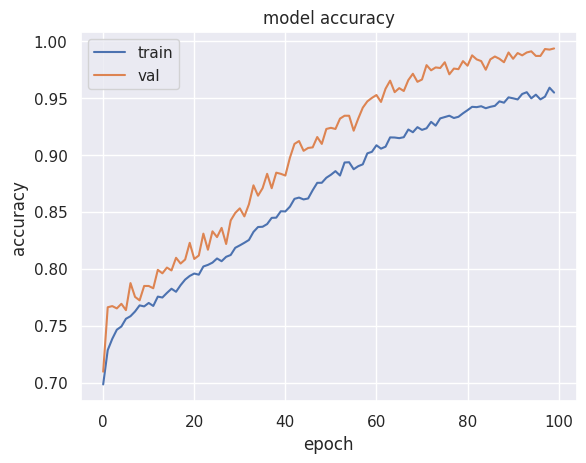

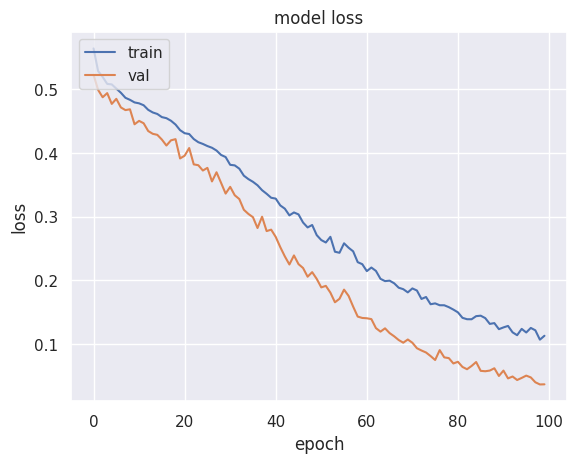

In [30]:
# Accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()


In [31]:
classifier_model.load_weights('model_google_embedding.h5')
classifier_model.evaluate(input_data_test,label_data_test)

preds = classifier_model.predict(input_data_test)
preds = tf.round(preds).numpy()
print(classification_report(label_data_test,preds,target_names = label_class, zero_division= 0))

12/12 [==============================] - 3s 188ms/step
              precision    recall  f1-score   support

       anger       0.57      0.45      0.50       121
anticipation       0.64      0.54      0.59       218
     disgust       0.65      0.60      0.62       156
        fear       0.67      0.52      0.58       195
         joy       0.28      0.14      0.19        70
        love       0.24      0.20      0.22        30
    optimism       0.38      0.43      0.40        97
   pessimism       0.45      0.53      0.48       120
     sadness       0.48      0.28      0.35       136
    surprise       0.27      0.12      0.17        49
       trust       0.30      0.25      0.27        60
     neutral       0.32      0.32      0.32        38

   micro avg       0.52      0.43      0.47      1290
   macro avg       0.44      0.37      0.39      1290
weighted avg       0.52      0.43      0.47      1290
 samples avg       0.45      0.42      0.40      1290



In [33]:
test_input = 'He was answering a question about the criticism by the same individual s that were referring to it as The Chinese and Wuhan Corona Virus'
def predect_sentiment(input,model):
  pred_result = classifier_model.predict([test_input])
  pred_result = list(tf.round(pred_result).numpy()[0])
  for v,l in zip(pred_result, label_class):
    if v == 1.0:
      print(l)

predect_sentiment(test_input, classifier_model)

1/1 [==============================] - 0s 67ms/step
disgust
joy


# Training with traditional LSTM + RNN

<Axes: >

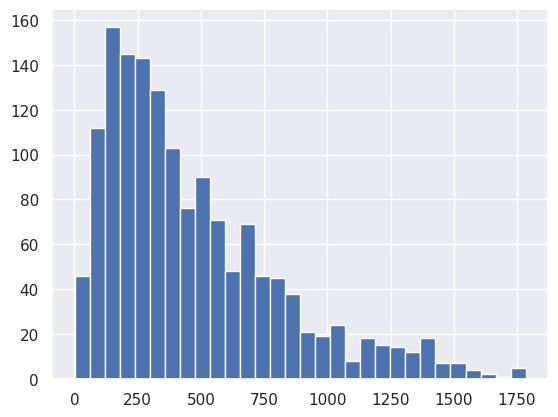

In [34]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in input_data_train]
pd.Series(seq_len).hist(bins = 30)

In [44]:
tokenizer_data = Tokenizer(oov_token='<OOV>',filters = '',split = ' ')
tokenizer_data.fit_on_texts(input_data_train)

tokenizer_data_train = tokenizer_data.texts_to_sequences(input_data_train)
vec_data_train = pad_sequences(tokenizer_data_train, padding = 'post', maxlen = 250)

tokenizer_data_val = tokenizer_data.texts_to_sequences(input_data_val)
vec_data_val = pad_sequences(tokenizer_data_val, padding = 'post', maxlen = 250)

data_vocab_size = len(tokenizer_data.word_index)+1
print('Input vector training: ', vec_data_train.shape)
print('Input vector val: ', vec_data_val.shape)
print('Vocab size: ', data_vocab_size)


Input vector training:  (1493, 250)
Input vector val:  (165, 250)
Vocab size:  69258


In [45]:
# training with traditional LSTM, RNN
dropout_threshold = 0.4
model2 = Sequential()
input_dim = data_vocab_size
output_dim = 60
input_length = 250

# Add Embedding layer
model2.add(Embedding(input_dim = input_dim,output_dim = output_dim,input_length = input_length))
# Add bidirectional LSTM
model2.add(Bidirectional(LSTM(units = output_dim, dropout = dropout_threshold, return_sequences = True)))

model2.add(Bidirectional(LSTM(units = output_dim, return_sequences=True)))
model2.add(GlobalAveragePooling1D())
model2.add(Dense(512,activation = 'relu'))
model2.add(Dropout(0.1))
model2.add(Dense(256,activation = 'relu'))
model2.add(Dropout(0.1))
model2.add(Dense(128,activation = 'relu'))
model2.add(Dropout(0.1))
model2.add(Dense(64,activation = 'relu'))
model2.add(Dropout(0.1))
model2.add(Dense(12,activation = 'sigmoid'))

adam = Adam(learning_rate=0.001)
model2.compile(optimizer= adam, loss = 'binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy(name= 'binary_accuracy',dtype = None, threshold = 0.5))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 60)           4155480   
                                                                 
 bidirectional_2 (Bidirecti  (None, 250, 120)          58080     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 250, 120)          86880     
 onal)                                                           
                                                                 
 global_average_pooling1d_1  (None, 120)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_34 (Dense)            (None, 512)               61952     
                                                      

In [46]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_google_embedding.h5',monitor= 'val_loss' )
hist = model2.fit(x = vec_data_train, y = label_data_train, epochs = 50,validation_data=(vec_data_val,label_data_val), callbacks = [callback_model])

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 0.5788 - binary_accuracy: 0.6992

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 22s 286ms/step - loss: 0.5788 - binary_accuracy: 0.6992 - val_loss: 0.5383 - val_binary_accuracy: 0.7126
Epoch 2/50
47/47 [==============================] - 13s 272ms/step - loss: 0.5343 - binary_accuracy: 0.7164 - val_loss: 0.5062 - val_binary_accuracy: 0.7333
Epoch 3/50
47/47 [==============================] - 12s 256ms/step - loss: 0.4945 - binary_accuracy: 0.7491 - val_loss: 0.4594 - val_binary_accuracy: 0.7742
Epoch 4/50
47/47 [==============================] - 14s 295ms/step - loss: 0.4559 - binary_accuracy: 0.7723 - val_loss: 0.4155 - val_binary_accuracy: 0.7904
Epoch 5/50
47/47 [==============================] - 11s 236ms/step - loss: 0.4272 - binary_accuracy: 0.7816 - val_loss: 0.3855 - val_binary_accuracy: 0.8157
Epoch 6/50
47/47 [==============================] - 13s 278ms/step - loss: 0.4017 - binary_accuracy: 0.7992 - val_loss: 0.3617 - val_binary_accuracy: 0.8202
Epoch 7/50
47/47 [==============================] - 8s 180ms/step - l

In [47]:
tokenized_data_test = tokenizer_data.texts_to_sequences(input_data_test)
vec_data_test = pad_sequences(tokenized_data_test, padding = 'post', maxlen = 250)

model2.load_weights('model_google_embedding.h5')
model2.evaluate(vec_data_test,label_data_test)

preds = model2.predict(vec_data_test)
preds = tf.round(preds).numpy()
print(classification_report(label_data_test,preds,target_names = label_class, zero_division= 0))

12/12 [==============================] - 2s 28ms/step
              precision    recall  f1-score   support

       anger       0.41      0.72      0.52       121
anticipation       0.64      0.58      0.61       218
     disgust       0.53      0.81      0.64       156
        fear       0.64      0.67      0.66       195
         joy       0.39      0.17      0.24        70
        love       0.16      0.20      0.18        30
    optimism       0.28      0.28      0.28        97
   pessimism       0.38      0.48      0.43       120
     sadness       0.41      0.46      0.44       136
    surprise       0.26      0.39      0.31        49
       trust       0.50      0.07      0.12        60
     neutral       0.50      0.03      0.05        38

   micro avg       0.47      0.51      0.49      1290
   macro avg       0.42      0.40      0.37      1290
weighted avg       0.48      0.51      0.47      1290
 samples avg       0.44      0.46      0.43      1290

